# Итоговый проект по курсу GeekBrains Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn

## Задание для курсового проекта
Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

#### Сдача проекта:
1. Срок сдачи: 05.02.2021
2. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook 
3. Необходимо получить R2 > 0.6 на Private Leaderboard
4. Ник на kaggle - alena77

Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

#### Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.

Подключение библиотек и скриптов

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/realestatepriceprediction/sample_submission.csv
/kaggle/input/realestatepriceprediction/train.csv
/kaggle/input/realestatepriceprediction/test.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import random
import warnings

from matplotlib import style
from sklearn import ensemble
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, GridSearchCV
from datetime import datetime
from pylab import rcParams

style.use('fivethirtyeight')
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Загрузка данных

In [5]:
TEST_DATASET_PATH = '/kaggle/input/realestatepriceprediction/test.csv'
TRAIN_DATASET_PATH = '/kaggle/input/realestatepriceprediction/train.csv'

test_data = pd.read_csv(TEST_DATASET_PATH)
train_data = pd.read_csv(TRAIN_DATASET_PATH)

**Описание датасета**

- **Id** - идентификационный номер квартиры
- **DistrictId** - идентификационный номер района
- **Rooms** - количество комнат
- **Square** - площадь
- **LifeSquare** - жилая площадь
- **KitchenSquare** - площадь кухни
- **Floor** - этаж
- **HouseFloor** - количество этажей в доме
- **HouseYear** - год постройки дома
- **Ecology_1**, **Ecology_2**, **Ecology_3** - экологические показатели местности
- **Social_1**, **Social_2**, **Social_3** - социальные показатели местности
- **Healthcare_1**, **Helthcare_2** - показатели местности, связанные с охраной здоровья
- **Shops_1**, **Shops_2** - показатели, связанные с наличием магазинов, торговых центров
- **Price** - цена квартиры

In [6]:
train_data.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


Анализ распределения целевой переменной в разрезе иных признаков

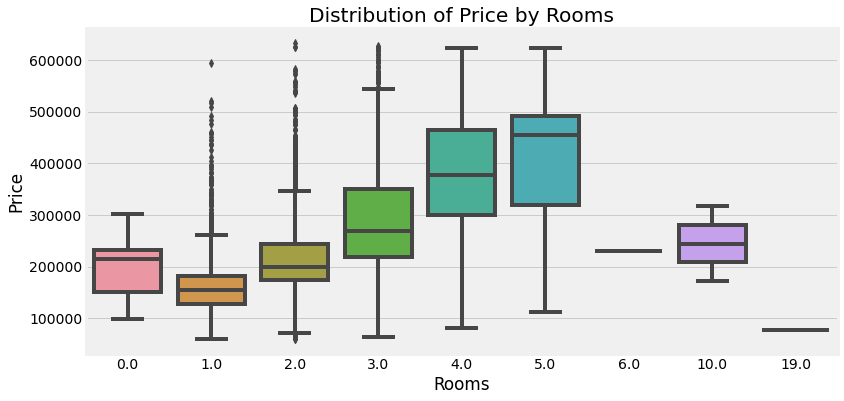

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(train_data['Rooms'], train_data['Price'])
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.title('Distribution of Price by Rooms')
plt.show()

Исключение малозначимых столбцов, содержащих количественные признаки

In [8]:
train_data.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>],
       [<AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'Price'}>]], dtype=object)

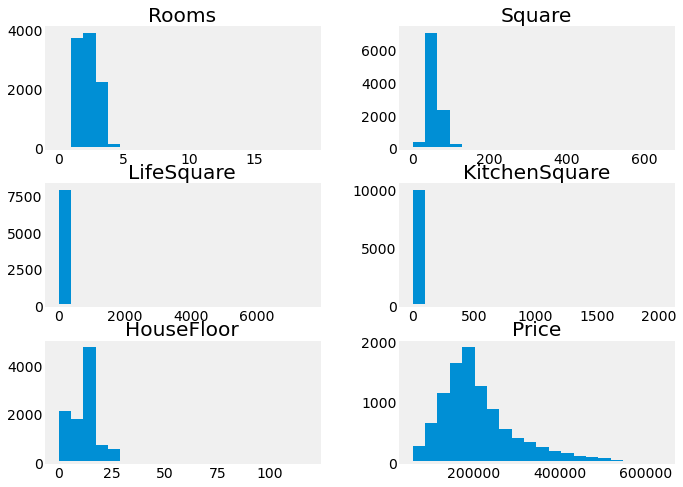

In [9]:
df_num_features = train_data.select_dtypes(include='float64')

num_features = pd.DataFrame(df_num_features)
num_features.drop('Ecology_1', axis=1, inplace=True)
num_features.drop('Healthcare_1', axis=1, inplace=True)
num_features.hist(figsize=(10, 8), bins=20, grid=False)

Взаимосвязь признаков

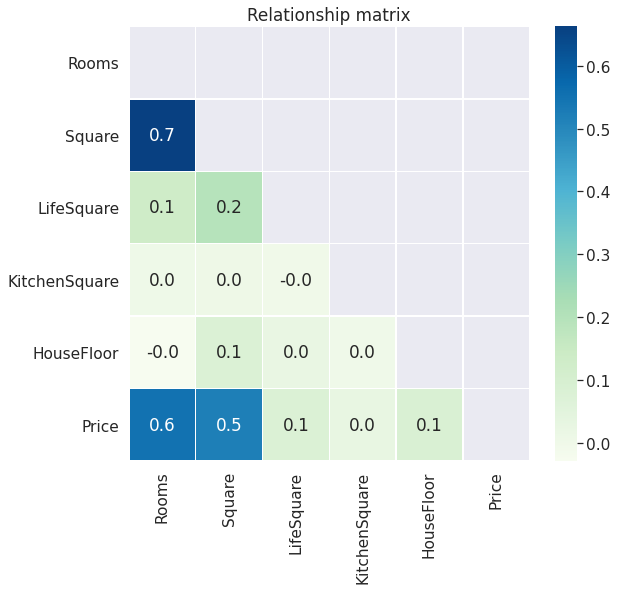

In [10]:
corr = num_features.corr()
plt.figure(figsize = (8, 8))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='GnBu')
plt.title('Relationship matrix')
plt.show()

In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Заполнение пропусков

In [12]:
train_data = train_data.sort_values('Price')
test_data = test_data.sort_values('DistrictId')
train_data = train_data.fillna(method='pad')
test_data = test_data.fillna(method='pad')

Проверка данных

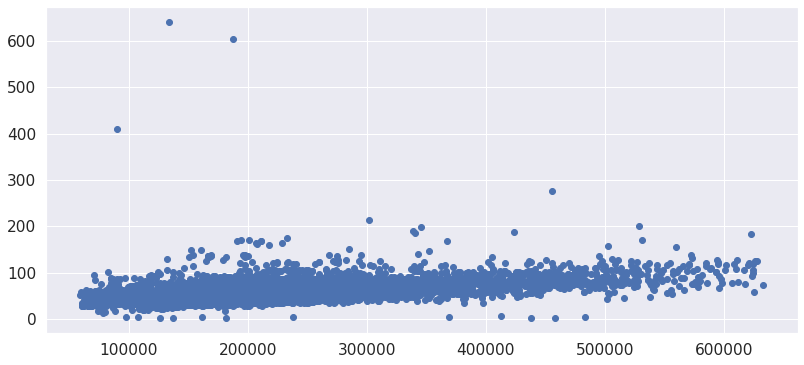

In [13]:
rcParams['figure.figsize'] = 12, 6  # изменение размера графиков

plt.scatter(train_data.Price, train_data.Square)

Формирование и обучение модели. Предсказание цен

In [14]:
# формирование модели

X_train = train_data.drop('Price', axis=1) # 1
y_train = train_data['Price'] # 1

X_test = test_data # 2

pr = pd.DataFrame()
pr['Id'] = X_test['Id'].copy() # 2.0

del_list = ["Id", "DistrictId", "LifeSquare", "Healthcare_1", "Ecology_2", "Ecology_3", "Shops_2"]
X_train.drop(del_list, axis=1, inplace=True) # 1
X_test.drop(del_list, axis=1, inplace=True) # 2

# обучение модели
model = RandomForestRegressor(n_estimators=1000, max_depth=16, random_state=42, max_features=7)
model.fit(X_train, y_train) # 1

y_pred = model.predict(X_test) # 2

# предсказание цен
pr['Price'] = y_pred # 2.0
pr.to_csv('predictions.csv', index=False) # 2.0